# CS3920 Assignment 2
___

- `Constants`

In [1]:
RANDOM_STATE: int = 42#mysteries among the universe

___
## import dataset

In [2]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
import pandas as pd

wine = datasets.load_wine()
wine_X= wine.data
wine_y= wine.target
print("Wine feature set: ",wine_X.shape)
print("Wine label set: ",wine_y.shape)
print("Wine Dataset imported sucessfully")


Wine feature set:  (178, 13)
Wine label set:  (178,)
Wine Dataset imported sucessfully


In [3]:
usps_test = np.genfromtxt("zip.test", delimiter=" ")
usps_train = np.genfromtxt("zip.train", delimiter=" ")
usps = np.append(usps_test, usps_train, axis=0)
usps_y, usps_X = usps[:, 0], usps[:, 1:]
usps_y = usps_y.astype("i")
print("USPS feature set: ",usps_X.shape)
print("USPS label set: ",usps_y.shape)
print("USPS Dataset imported sucessfully")

USPS feature set:  (9298, 256)
USPS label set:  (9298,)
USPS Dataset imported sucessfully


In [4]:
del usps_test, usps_train, usps, wine

___
## Task Unit __class__

In [5]:


class Tasks:
    def __init__(self,data_X:np.ndarray, data_y:np.ndarray, target_space:list):
        self.X = data_X
        self.y = data_y
        self.target_space = target_space

    def split(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        list = train_test_split(self.X,
            self.y, random_state=RANDOM_STATE, test_size=0.2)
        self.train = (list[0], list[2])
        self.test = (list[1], list[3])
        return (self.train, self.test)

    def validate(self, svm):
        return np.mean(cross_val_score(svm, self.train[0], self.train[1]))


    def test_error(self, svm):
        svm.fit(self.train[0], self.train[1])
        return 1 - svm.score(self.test[0], self.test[1])


    def pipeline(self, svm=SVC()):

        return Pipeline(steps=[('scaler',None), ("svm", svm)])



    def gridsearch(self, pipe, param_grid):
        self.grid =  GridSearchCV(pipe, param_grid=param_grid, cv=5)
        return self.grid.fit(self.train[0], self.train[1])

    def cross_conformal(self, pipe = None, test= None, n=5):
        if pipe is None:
            pipe = self.grid.best_estimator_
        if test is None:
            test = self.test
        return self.c_c(pipe, test, n)

    def c_c(self, pipe , test, n):
        kf = KFold(n_splits=n, shuffle=True, random_state=RANDOM_STATE)
        pval = np.ones([test[1].shape[0], len(self.target_space)])
        est = pipe
        for rest, fold in kf.split(self.train[0]):
            X_rest, X_fold = self.train[0][rest], self.train[0][fold]
            y_rest, y_fold = self.train[1][rest], self.train[1][fold]
            est.fit(X_rest, y_rest)
            r_fold = est.decision_function(X_fold)
            conformity_score_test = est.decision_function(test[0])
            for index,element in enumerate(conformity_score_test):
                k =np.zeros([len(self.target_space),])
                for e in r_fold:
                    x = e<=element
                    k = k+x
                pval[index] = pval[index]+k
        div = self.train[1].shape[0]+1
        return pval/div
    

    def false_p(self, pval, test=None):
        if test is None:
            test = self.test[1].astype("i")
        return self.f_p(pval, test)
    
    def f_p(self,pval,test):
        a = np.zeros([pval.shape[0],])
        for i, e in enumerate(pval):
            a[i] = np.mean(np.delete(e, test[i],0))
        return a


    def plot_error_rate(self, p_val,test=None):
        if test is None:
            test = self.test[1]
        %matplotlib inline
        n_test = test.shape[0]
        eps = np.zeros(100) # a range of significance levels
        err = np.zeros(100) # the corresponding error rates
        for k in range(100):
            eps[k] = k/100 # considering eps = k%
            err[k] = 0 # initializing the error rate
            for j in range(n_test):
                if (p_val[j,test[j]] <= eps[k]): # if we made an error
                    err[k] = err[k] + 1 # count this error
            err[k] = err[k] / n_test# number of errors -> error rate
        plt.title("Test Score Comparison")
        plt.ylabel('Error rate')
        plt.xlabel('Significance level (ε)')
        plt.plot(eps,err)









___
## Run tasks: Wine

In [6]:
task1:Tasks = Tasks(wine_X, wine_y, [0,1,2])


- Question 2:

    Splitting `DataSet`

In [7]:
x = task1.split()
print("Training set's feature: ",x[0][0].shape)
print("Training set's label: ",x[0][1].shape)
print("Testing set's feature: ",x[1][0].shape)
print("Testing set's label: ",x[1][1].shape)

Training set's feature:  (142, 13)
Training set's label:  (142,)
Testing set's feature:  (36, 13)
Testing set's label:  (36,)


- Question 3:

    `Cross-Validation`

- default SVM

In [8]:
svm = SVC()

In [9]:
cvs = task1.validate(svm)
print("Cross-validation accuracy: {:.10f}".format(cvs))

Cross-validation accuracy: 0.7029556650


- Question 4:

    `Test Error Rate`

- default SVM

In [10]:
svm = SVC()

In [11]:
t_score = task1.test_error(svm)
print("Test error rate: {:.10f}".format(t_score))

Test error rate: 0.3333333333


- Question 5:

    Pipeline tuning

In [12]:
def params():

  scalers = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
    Normalizer(),
  ]

  param_grid = [{'scaler': scalers,
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    ,'svm__kernel': ['poly', 'rbf', 'sigmoid']
    }
    ,{'scaler': scalers,
      'svm__C': [0.1, 1, 10, 100, 1000],
      'svm__kernel': ['linear']
    }
  ]

  return param_grid

- The Dictionary `param_grid` containing a grid of hyperparameters to be used in a `GridSearchCV`
- `param_grid` contains four __unique__ parameters:
    - __C__ : `svm__C` determines the strength of regularization
    - __γ__ : `svm__gamma` determines the strength of the non-linearity of the model
    - __Kernel__ : `svm__kernel` determines the kernel type to be used in the __SVM__
    - __Scaler__ : `scaler` determines the scaler to be used in `GridSearchCV`


In [13]:
k = task1.pipeline(SVC())
gs = task1.gridsearch(k, params())
results=gs.cv_results_
results["params"]
params = pd.DataFrame(results["params"])
m_t_s = pd.DataFrame(results["mean_test_score"], columns=["Accuracy"])
df =pd.concat([params,m_t_s],axis=1)

- The result of the grid search is displayed in a panda `DataFrame`

In [14]:
def sortDf(df3):
    df1 = df3.sort_values("Accuracy", ascending=False)
    return df1.head(20)
show = sortDf(df)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show


Best Test error rate: 0.0140394089


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
43,StandardScaler(),1.0,0.100,rbf,0.985961
130,RobustScaler(),1.0,0.010,rbf,0.985714
133,RobustScaler(),1.0,0.100,rbf,0.978818
226,MinMaxScaler(),1.0,1.000,rbf,0.978818
74,StandardScaler(),100.0,0.001,sigmoid,0.978571
42,StandardScaler(),1.0,0.100,poly,0.978571
58,StandardScaler(),10.0,0.010,rbf,0.978571
59,StandardScaler(),10.0,0.010,sigmoid,0.978571
360,StandardScaler(),0.1,NaN,linear,0.978571
134,RobustScaler(),1.0,0.100,sigmoid,0.978571


- These are the first __20__ estimator pipeline with this highest accuracy

In [15]:
def findDf(df3, key:str, value):
    l = []
    for i,e in enumerate(df["scaler"]):
        if isinstance(e, value):
            l.append(i)
    return sortDf(df3.loc[l])
show = findDf(df, "scaler", StandardScaler)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0140394089


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
43,StandardScaler(),1.0,0.100,rbf,0.985961
59,StandardScaler(),10.0,0.010,sigmoid,0.978571
74,StandardScaler(),100.0,0.001,sigmoid,0.978571
360,StandardScaler(),0.1,NaN,linear,0.978571
58,StandardScaler(),10.0,0.010,rbf,0.978571
42,StandardScaler(),1.0,0.100,poly,0.978571
55,StandardScaler(),10.0,0.001,rbf,0.978571
56,StandardScaler(),10.0,0.001,sigmoid,0.978571
41,StandardScaler(),1.0,0.010,sigmoid,0.978571
26,StandardScaler(),0.1,0.100,sigmoid,0.971675


- These are the first __20__ `StandardScaler()` estimator pipeline sorted with accuracy

In [16]:
show =findDf(df, "scaler", MinMaxScaler)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0211822660


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
226,MinMaxScaler(),1.0,1.000,rbf,0.978818
223,MinMaxScaler(),1.0,0.100,rbf,0.978571
238,MinMaxScaler(),10.0,0.010,rbf,0.978571
253,MinMaxScaler(),100.0,0.001,rbf,0.978571
242,MinMaxScaler(),10.0,0.100,sigmoid,0.978571
257,MinMaxScaler(),100.0,0.010,sigmoid,0.978571
371,MinMaxScaler(),1.0,NaN,linear,0.978571
262,MinMaxScaler(),100.0,1.000,rbf,0.971675
244,MinMaxScaler(),10.0,1.000,rbf,0.971675
370,MinMaxScaler(),0.1,NaN,linear,0.971429


- These are the first __20__ `MinMaxScaler()` estimator pipeline sorted with accuracy

In [17]:
show =findDf(df, "scaler", RobustScaler)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0142857143


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
130,RobustScaler(),1.0,0.010,rbf,0.985714
133,RobustScaler(),1.0,0.100,rbf,0.978818
134,RobustScaler(),1.0,0.100,sigmoid,0.978571
145,RobustScaler(),10.0,0.001,rbf,0.978571
365,RobustScaler(),0.1,NaN,linear,0.971675
148,RobustScaler(),10.0,0.010,rbf,0.971675
149,RobustScaler(),10.0,0.010,sigmoid,0.971675
116,RobustScaler(),0.1,0.100,sigmoid,0.971675
163,RobustScaler(),100.0,0.001,rbf,0.971675
164,RobustScaler(),100.0,0.001,sigmoid,0.971675


- These are the first __20__ `RobustScaler()` estimator pipeline sorted with accuracy

In [18]:
show =findDf(df, "scaler", Normalizer)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0423645320


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
358,Normalizer(),100.00,100.0,rbf,0.957635
285,Normalizer(),0.01,100.0,poly,0.936453
336,Normalizer(),10.00,10.0,poly,0.936453
355,Normalizer(),100.00,10.0,rbf,0.922660
318,Normalizer(),1.00,10.0,poly,0.922414
303,Normalizer(),0.10,100.0,poly,0.922167
354,Normalizer(),100.00,10.0,poly,0.922167
321,Normalizer(),1.00,100.0,poly,0.908128
357,Normalizer(),100.00,100.0,poly,0.908128
339,Normalizer(),10.00,100.0,poly,0.908128


- These are the first __20__ `Normalizer()` estimator pipeline sorted with accuracy

In [19]:
def filterDf(df3, key:str, value):
    df3 = df3[df3[key] == value]
    return sortDf(df3)

show =filterDf(df, 'svm__kernel', 'linear')
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0214285714


,scaler,svm__C,svm__gamma,svm__kernel,Accuracy
360,StandardScaler(),0.1,NaN,linear,0.978571
371,MinMaxScaler(),1.0,NaN,linear,0.978571
365,RobustScaler(),0.1,NaN,linear,0.971675
370,MinMaxScaler(),0.1,NaN,linear,0.971429
367,RobustScaler(),10.0,NaN,linear,0.964532
368,RobustScaler(),100.0,NaN,linear,0.964532
369,RobustScaler(),1000.0,NaN,linear,0.964532
364,StandardScaler(),1000.0,NaN,linear,0.964286
363,StandardScaler(),100.0,NaN,linear,0.964286
361,StandardScaler(),1.0,NaN,linear,0.964286


- These are the first __20__ `linear svm__kernel` estimator pipeline sorted with accuracy

- __Best performing Pipeline__

In [20]:
print("Best cross-validation accuracy:", gs.best_score_)
print("Test set score:", gs.score(*x[1]))
print("Best parameters:", gs.best_params_)

Best cross-validation accuracy: 0.9859605911330049
Test set score: 1.0
Best parameters: {'scaler': StandardScaler(), 'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


- `GridSearchCV` __Test Error Rate__

In [21]:
t_score = task1.test_error(gs)
print("Test error rate: {:.10f}".format(t_score))

Test error rate: 0.0000000000


-  __Calibration Curve__

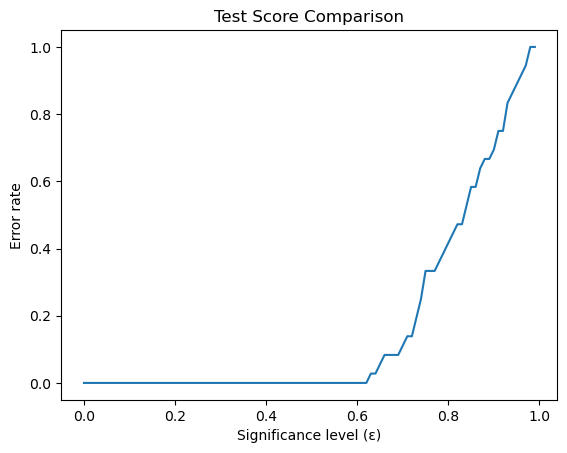

In [22]:
pipe = make_pipeline(StandardScaler(), SVC(C=1, gamma=0.1, kernel="rbf"))
pval = task1.cross_conformal(pipe = pipe, n=10)
task1.plot_error_rate(pval)

- __Average False P-Value__ on the test set 

In [23]:
avfp =np.mean(task1.false_p(pval))
print("Average False P-Value: {:.10f}".format(t_score))

Average False P-Value: 0.0000000000


___
## Run tasks: USPS

In [24]:
task2:Tasks = Tasks(usps_X, usps_y, [0,1,2,3,4,5,6,7,8,9])


- Question 2:

    Splitting `DataSet`

In [25]:
x = task2.split()
print("Training set's feature: ",x[0][0].shape)
print("Training set's label: ",x[0][1].shape)
print("Testing set's feature: ",x[1][0].shape)
print("Testing set's label: ",x[1][1].shape)

Training set's feature:  (7438, 256)
Training set's label:  (7438,)
Testing set's feature:  (1860, 256)
Testing set's label:  (1860,)


- Question 3:

    `Cross-Validation`

- default SVM

In [26]:
svm = SVC()

In [27]:
cvs = task2.validate(svm)
print("Cross-validation accuracy: {:.10f}".format(cvs))

Cross-validation accuracy: 0.9710936540


- Question 4:

    `Test Error Rate`

- default SVM

In [28]:
svm = SVC()

In [29]:
t_score = task2.test_error(svm)
print("Test error rate: {:.10f}".format(t_score))

Test error rate: 0.0263440860


- Question 5:

    Pipeline tuning

In [30]:
def params():

  scalers = [
    StandardScaler(),
    MinMaxScaler(),
    Normalizer(),
  ]

  param_grid = [{'scaler': scalers,
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    }
  ]

  return param_grid

- The Dictionary `param_grid` containing a grid of hyperparameters to be used in a `GridSearchCV`
- `param_grid` contains four __unique__ parameters:
    - __C__ : `svm__C` determines the strength of regularization
    - __γ__ : `svm__gamma` determines the strength of the non-linearity of the model
    - __Kernel__ : `svm__kernel` determines the kernel type to be used in the __SVM__
    - __Scaler__ : `scaler` determines the scaler to be used in `GridSearchCV`


In [31]:
k = task2.pipeline(SVC())
gs = task2.gridsearch(k, params())
results=gs.cv_results_
results["params"]
params = pd.DataFrame(results["params"])
m_t_s = pd.DataFrame(results["mean_test_score"], columns=["Accuracy"])
df =pd.concat([params,m_t_s],axis=1)

- The result of the grid search is displayed in a panda `DataFrame`

In [32]:
def sortDf(df3):
    df1 = df3.sort_values("Accuracy", ascending=False)
    return df1.head(20)
show = sortDf(df)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show


Best Test error rate: 0.0264858161


,scaler,svm__C,svm__gamma,Accuracy
81,Normalizer(),10.0,1.000,0.973514
87,Normalizer(),100.0,1.000,0.972842
49,MinMaxScaler(),10.0,0.010,0.970691
55,MinMaxScaler(),100.0,0.010,0.969481
18,StandardScaler(),10.0,0.001,0.968271
75,Normalizer(),1.0,1.000,0.967733
56,MinMaxScaler(),100.0,0.100,0.965985
50,MinMaxScaler(),10.0,0.100,0.965985
24,StandardScaler(),100.0,0.001,0.965179
44,MinMaxScaler(),1.0,0.100,0.963430


- These are the first __20__ estimator pipeline with this highest accuracy

In [33]:
def findDf(df3, key:str, value):
    l = []
    for i,e in enumerate(df["scaler"]):
        if isinstance(e, value):
            l.append(i)
    return sortDf(df3.loc[l])
show = findDf(df, "scaler", StandardScaler)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0317288363


,scaler,svm__C,svm__gamma,Accuracy
18,StandardScaler(),10.00,0.001,0.968271
24,StandardScaler(),100.00,0.001,0.965179
12,StandardScaler(),1.00,0.001,0.958725
19,StandardScaler(),10.00,0.010,0.932510
25,StandardScaler(),100.00,0.010,0.932241
13,StandardScaler(),1.00,0.010,0.927669
6,StandardScaler(),0.10,0.001,0.918257
7,StandardScaler(),0.10,0.010,0.814466
0,StandardScaler(),0.01,0.001,0.401048
26,StandardScaler(),100.00,0.100,0.321190


- These are the first __20__ `StandardScaler()` estimator pipeline sorted with accuracy

In [34]:
show =findDf(df, "scaler", MinMaxScaler)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0293086680


,scaler,svm__C,svm__gamma,Accuracy
49,MinMaxScaler(),10.00,0.010,0.970691
55,MinMaxScaler(),100.00,0.010,0.969481
50,MinMaxScaler(),10.00,0.100,0.965985
56,MinMaxScaler(),100.00,0.100,0.965985
44,MinMaxScaler(),1.00,0.100,0.963430
43,MinMaxScaler(),1.00,0.010,0.961010
54,MinMaxScaler(),100.00,0.001,0.957918
48,MinMaxScaler(),10.00,0.001,0.955095
37,MinMaxScaler(),0.10,0.010,0.929013
42,MinMaxScaler(),1.00,0.001,0.928609


- These are the first __20__ `MinMaxScaler()` estimator pipeline sorted with accuracy

In [35]:
show =findDf(df, "scaler", Normalizer)
t_score = 1-show["Accuracy"].iloc[0]
print("Best Test error rate: {:.10f}".format(t_score))
show

Best Test error rate: 0.0264858161


,scaler,svm__C,svm__gamma,Accuracy
81,Normalizer(),10.00,1.000,0.973514
87,Normalizer(),100.00,1.000,0.972842
75,Normalizer(),1.00,1.000,0.967733
86,Normalizer(),100.00,0.100,0.957919
80,Normalizer(),10.00,0.100,0.957380
85,Normalizer(),100.00,0.010,0.954691
74,Normalizer(),1.00,0.100,0.940844
79,Normalizer(),10.00,0.010,0.939231
84,Normalizer(),100.00,0.001,0.938962
69,Normalizer(),0.10,1.000,0.938827


- These are the first __20__ `Normalizer()` estimator pipeline sorted with accuracy

- __Best performing Pipeline__

In [36]:
print("Best cross-validation accuracy:", gs.best_score_)
print("Test set score:", gs.score(*x[1]))
print("Best parameters:", gs.best_params_)

Best cross-validation accuracy: 0.9735141838586747
Test set score: 0.9817204301075269
Best parameters: {'scaler': Normalizer(), 'svm__C': 10, 'svm__gamma': 1}


- `GridSearchCV` __Test Error Rate__

In [37]:
t_score= gs.score(*x[1])
print("Test error rate: {:.10f}".format(1-t_score))

Test error rate: 0.0182795699


-  __Calibration Curve__

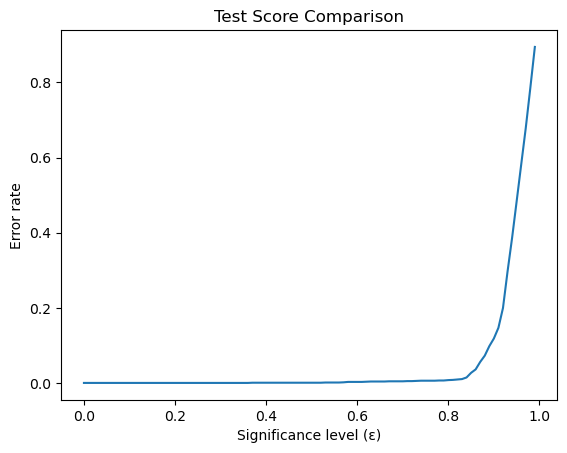

In [38]:
pipe = make_pipeline(Normalizer(), SVC(C=10, gamma=1))
pval = task2.cross_conformal(pipe = pipe, n=10)
task2.plot_error_rate(pval)

- __Average False P-Value__ on the test set 

In [39]:
avfp =np.mean(task2.false_p(pval))
print("Average False P-Value: {:.10f}".format(t_score))

Average False P-Value: 0.9817204301
